## Demo


In [1]:
import os, cv2
import numpy as np
import scipy.signal
from PIL import Image
from Unet_model import Unet
import matplotlib
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread, imshow
import os, cv2
import numpy as np
import scipy.signal
from PIL import Image
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.io import imread, imshow
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.metrics import calinski_harabaz_score

Using TensorFlow backend.


In [3]:
#Load Images
B1, B2, lim = [], [], 20
for i,e in enumerate(os.listdir('./img/')):
    if i >= lim:
        break
    I = imread('./img/' + e)
    IMG = resize(I, (800, 800, 3), mode='constant', preserve_range=True)
    IMG = IMG + [10, 15, 18]
    B1.append(IMG)
#     B2.append(MSK)
    if i% 50 == 0:
        print(i, e)
# msk_batch = np.array(B2)
# img_batch.shape, msk_batch.shape

0 P1030811.JPG.jpeg


In [4]:
img_batch = np.array(B1)
img_batch = np.asarray(img_batch, dtype=np.float32)/img_batch.max()
img_batch.shape, img_batch.max()

((20, 800, 800, 3), 1.0)

In [7]:
#Load weight and Segmentation
model = Unet(input_shape=(800, 800, 3)) 
model.load_weights('new_test.h5')
preds_test = model.predict(img_batch , batch_size = 1, verbose = 1)

20/20 [==============================] - 151s 8s/step


In [8]:
#Define functions
def mid(line):
    x1, x2 = line[0], line[2]
    y1, y2 = line[1], line[3]
    x_mid, y_mid = int(np.round((x1+x2)/2)), int(np.round((y1+y2)/2))
    return (x_mid, y_mid)
def crs(a1,b1,a2,b2):
    return a1*b2 - b1*a2
def converse(line1, line2):
    x1, y1, x2, y2 = line1
    a1, b1, c1 = (y2 - y1), (x2- x1), (x2*y1 - x1*y2)
    x3, y3, x4, y4 = line2
    a2, b2, c2 = (y4 - y3), (x4- x3), (x4*y3 - x3*y4)
    r1, r2 = int(np.round(crs(b1,c1,b2,c2)/crs(a1,b1,a2,b2))), int(np.round(crs(a1,c1,a2,c2)/crs(a1,b1,a2,b2)))
    return (r1, r2)
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]
def seg(line1, line2):
    return [(line1[0], line1[1]), (line2[0], line2[1])], [(line1[2], line1[3]), (line2[2], line2[3])]
def length(line):
    x1, x2 = line[0], line[2]
    y1, y2 = line[1], line[3]
    return np.sqrt((y2-y1)**2 + (x2-x1)**2)
def grad(line):
    x1, x2 = line[0], line[2]
    y1, y2 = line[1], line[3]
    return np.float64((y2- y1)/(x2-x1))
def mid(line):
    x1, x2 = line[0], line[2]
    y1, y2 = line[1], line[3]
    return (int(np.round((x1+x2)/2)), int(np.round((y1+y2)/2)))
def vanishingp(line1, line2):
    x1, y1, x2, y2 = line1[0], line1[1], line1[2], line1[3]
    x3, y3, x4, y4 = line2[0], line2[1], line2[2], line2[3]
    
    x_diff = (x1 - x3, x2 - x4)
    y_diff = (y1 - y3, y2 - y4)

    div = det(x_diff, y_diff)
    if div == 0:
        return None
    d = (det([x1, y1],[x3, y3]), det([x2, y2],[x4, y4]))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div
    return int(x), int(y)
def merge(line1, line2):
    x1, y1, x2, y2 = line1[0], line1[1], line1[2], line1[3]
    x3, y3, x4, y4 = line2[0], line2[1], line2[2], line2[3]
    xtl, xtr = min([x1, x2, x3, x4]), max([x1, x2, x3, x4])
    ytl, ytr = y1, y4
    return (xtl, ytl, xtr, ytr)
def detect(line1, line2):
    x1, y1, x2, y2 = line1[0], line1[1], line1[2], line1[3]
    x3, y3, x4, y4 = line2[0], line2[1], line2[2], line2[3]
    a1, b1, c1 = (y2 - y1), (x2- x1), (x2*y1 - x1*y2)
    a2, b2, c2 = (y4 - y3), (x4- x3), (x4*y3 - x3*y4)
    if crs(a1,b1,a2,b2) == 0:
        return crs(b1,c1,b2,c2)/(1+crs(a1,b1,a2,b2))
    else: return crs(b1,c1,b2,c2)/crs(a1,b1,a2,b2)
def conn(lineset):
    refine = []
    for line1 in lineset:
        for line2 in lineset:
            if line1 != line2 and 0 < detect(line1, line2) < 800:
                refine.append(merge(line1, line2))
                if line1 in lineset: lineset.remove(line1)
                if line2 in lineset: lineset.remove(line2)
    return lineset, refine
def ladder(lineset):
    copy = lineset
    SET, length = [], []
    for ind, ele in enumerate(lineset):
        set_i = []
        tmp = ele
        linset = copy
        tmp_set =  [x for x in lineset if x != ele]
#         print(tmp, len(tmp_set))
        for x1, y1, x2, y2 in tmp_set:
            if x1 > tmp[0] and x2 < tmp[2] and y1 < tmp[1] and y2 < tmp[3]:
                set_i.append([x1, y1, x2, y2])
                tmp = [x1,y1,x2,y2]
        SET.append(set_i)
        length.append(len(set_i))
    return SET[length.index(max(length))]
def clustering(lineset, n_clusters):
    check = []
    for line in lineset:
        check.append(mid(line))
    Xtr = np.array(check)
    if len(list(Xtr.shape)) == 1:
        Xtr = Xtr.reshape(-1,1)
    label = MiniBatchKMeans(n_clusters = n_clusters, 
                            batch_size = 7, 
                            random_state = 233).fit_predict(Xtr)
    score = metrics.calinski_harabaz_score(Xtr, label)
    labels = np.where(label == label[np.argmax(np.bincount(label))])
    refine = np.array(lineset)[labels].tolist()
    return refine
def vector(lineset):
    start_point, end_point = sorted(lineset)[0], sorted(lineset)[-1]
    if start_point[1] < end_point[1]:
        return end_point, start_point
    else:
        return start_point, end_point

In [ ]:
#Hough Transfer Progress
for i in [11]:
    T = 0.5
    kernelSize = (7, 7)
    threshold1 = 50
    threshold2 = 100
    houghTransformThreshold = 80
    houghTransformMinLineLength = 100
    houghTransformMaxLineGap = 100
    preds_test_t2 = (preds_test > T).astype(np.uint8)
    img = np.squeeze(img_batch[i]).copy()
    img_color = np.array(img.copy()*255, dtype = np.uint8)
    gray = np.squeeze(preds_test_t2[i]).copy()
    lane = cv2.Canny(gray.copy()*125, 
                     threshold1 = threshold1, threshold2 = threshold2, apertureSize = 5, L2gradient = True)
    Lineset = cv2.HoughLinesP(lane.copy(), rho = 1.0, theta = np.pi/360, 
                                 threshold = houghTransformThreshold, 
                                 minLineLength = houghTransformMinLineLength, 
                                 maxLineGap = houghTransformMaxLineGap)  # lineset is the list of lines
    if Lineset != np.array([]):
        origin_set, midpoint = [], []
        for lines in Lineset:
            for x1, y1, x2, y2 in lines:
                if 1 > abs((y2-y1)/(x2-x1))> 0.1:
                    origin_set.append([x1, y1, x2, y2])
                    midpoint.append(mid([x1, y1, x2, y2]))
        if origin_set != []:
            img_color_ori = img_color.copy()
            for x1, y1, x2, y2 in origin_set:
                cv2.line(img_color_ori, (x1, y1), (x2, y2),(255, 128, 0), 2)
            img_color_line = img_color.copy()
            LINE = ladder(origin_set)
            for x1, y1, x2, y2 in LINE: 
                cv2.line(img_color_line, (x1, y1), (x2, y2),(255, 0, 0), 2)
            line_s, refine_s = conn(origin_set)
            Union = line_s + refine_s
            if len(LINE) >= 2:
                VP = vanishingp(sorted(LINE)[0],sorted(LINE)[-1])
                O = mid(LINE[0])
                Linel, Liner = seg(sorted(LINE)[0], sorted(LINE)[-1])
                cv2.circle(img_color_line, VP, 1, (255, 0, 255), 12)
                cv2.line(img_color_line, Linel[0],Linel[1],(255, 0, 255), 4)
                cv2.line(img_color_line, Liner[0],Liner[1],(255, 0, 255), 4)
            CONV = []
            for x1, y1, x2, y2 in Union:
                Vline = [VP[0], VP[1], O[0], O[1]]
                cov = converse(Vline, [x1, y1, x2, y2])
                CONV.append(cov)
            if len(CONV) >= 2:
                start_p, end_p = vector(CONV)
                cv2.line(img_color, start_p, end_p, (255,255,0), 6)
                cv2.circle(img_color, start_p, 1,(0, 255, 255), 12)
                cv2.circle(img_color, end_p, 1,(255, 0, 0), 12)

img


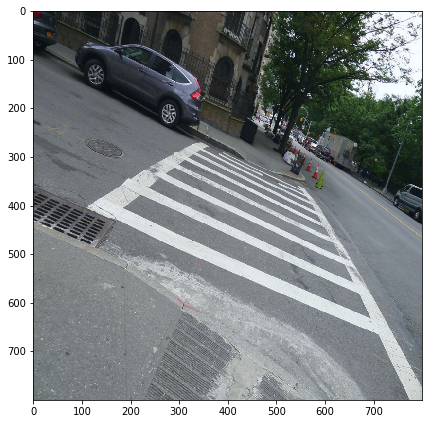

img_color


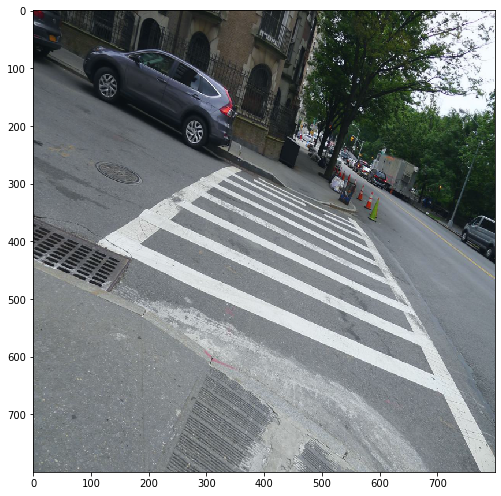

segmentation


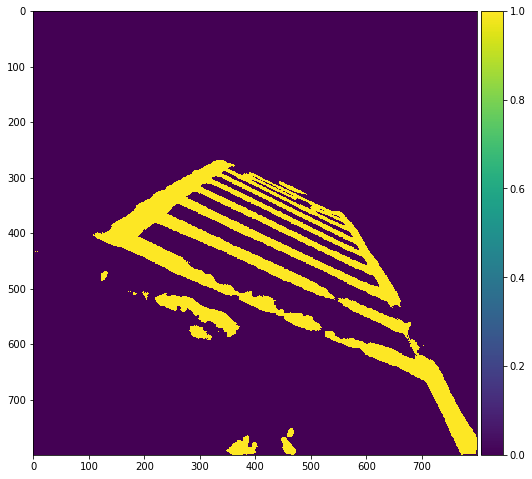

gray


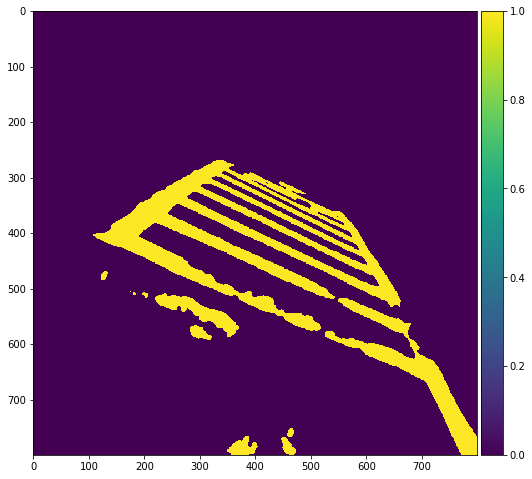

lane


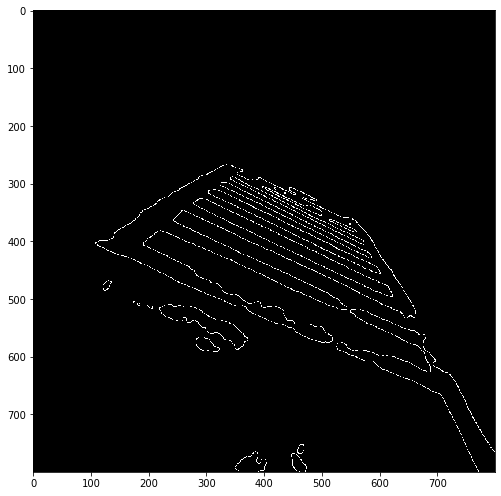

C:\Users\s7532\AppData\Local\Anaconda\miniconda\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Hough Transform


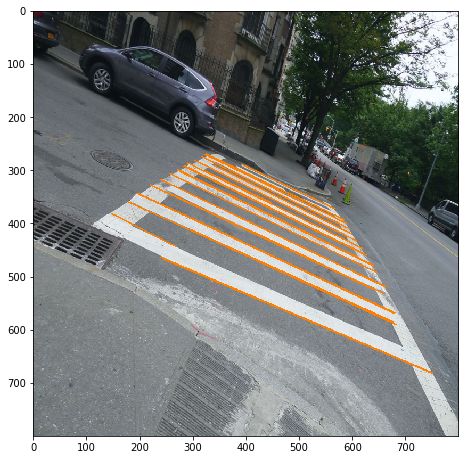

Ladder filter


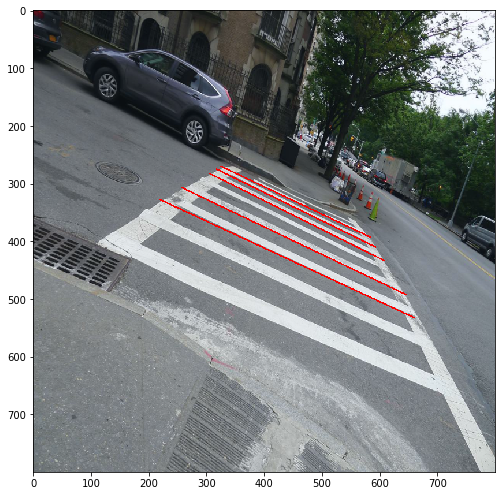

[(220, 328), (325, 270)] [(659, 532), (584, 393)]
Vanishing Point


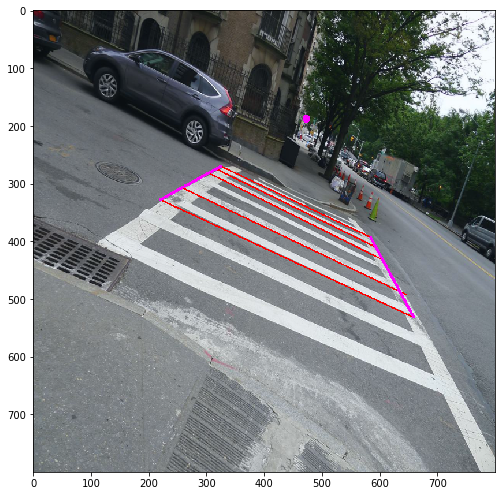

Detection result


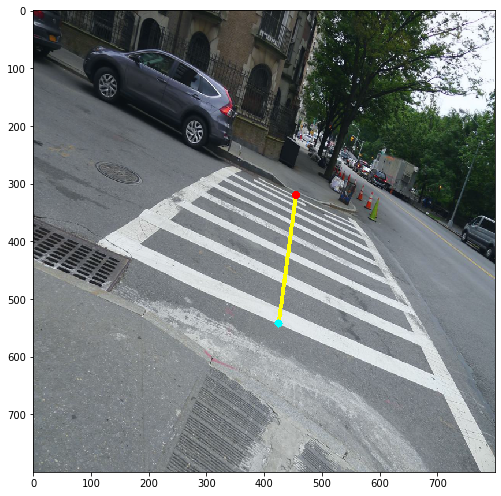

In [38]:
#Hough Transfer Demo
for i in [11]:
    T = 0.5
    kernelSize = (7, 7)
    threshold1 = 50
    threshold2 = 100
    houghTransformThreshold = 80
    houghTransformMinLineLength = 100
    houghTransformMaxLineGap = 100
    preds_test_t2 = (preds_test > T).astype(np.uint8)
    img = np.squeeze(img_batch[i]).copy()
    print('img')
    plt.figure(figsize = (6, 6))
    imshow(img)
    plt.show()
    img_color = np.array(img.copy()*255, dtype = np.uint8)
    print('img_color')
    plt.figure(figsize = (7, 7))
    imshow(img_color)
    plt.show()
    gray = np.squeeze(preds_test_t2[i]).copy()
    print('segmentation')
    plt.figure(figsize = (7.5, 7.5))
    imshow(img3)
    plt.show()
    lane = cv2.Canny(gray.copy()*125, 
                     threshold1 = threshold1, threshold2 = threshold2, apertureSize = 5, L2gradient = True)
    print('lane')
    plt.figure(figsize = (7, 7))
    imshow(lane)
    plt.show()
    Lineset = cv2.HoughLinesP(lane.copy(), rho = 1.0, theta = np.pi/360, 
                                 threshold = houghTransformThreshold, 
                                 minLineLength = houghTransformMinLineLength, 
                                 maxLineGap = houghTransformMaxLineGap)  # lineset is the list of lines
    if Lineset != np.array([]):
        origin_set, midpoint = [], []
        for lines in Lineset:
            for x1, y1, x2, y2 in lines:
                if 1 > abs((y2-y1)/(x2-x1))> 0.1:
                    origin_set.append([x1, y1, x2, y2])
                    midpoint.append(mid([x1, y1, x2, y2]))
        if origin_set != []:
            img_color_ori = img_color.copy()
            for x1, y1, x2, y2 in origin_set:
                cv2.line(img_color_ori, (x1, y1), (x2, y2),(255, 128, 0), 2)
            print('Hough Transform')
            plt.figure(figsize = (6.5, 6.5))
            imshow(img_color_ori)
            plt.show()
            
#                                     cv2.circle(img1, (int((x1 + x2)/2), int((y1 + y2)/2)), 1, (255, 255, 255), 4)
            img_color_line = img_color.copy()
            LINE = ladder(origin_set)
            for x1, y1, x2, y2 in LINE: 
                cv2.line(img_color_line, (x1, y1), (x2, y2),(255, 0, 0), 2)
            print('Ladder filter')
            plt.figure(figsize = (7, 7))
            imshow(img_color_line)
            plt.show()
            
            line_s, refine_s = conn(origin_set)
            Union = line_s + refine_s
            if len(LINE) >= 2:
                VP = vanishingp(sorted(LINE)[0],sorted(LINE)[-1])
                O = mid(LINE[0])
                Linel, Liner = seg(sorted(LINE)[0], sorted(LINE)[-1])
                print(Linel, Liner)
                cv2.circle(img_color_line, VP, 1, (255, 0, 255), 12)
                cv2.line(img_color_line, Linel[0],Linel[1],(255, 0, 255), 4)
                cv2.line(img_color_line, Liner[0],Liner[1],(255, 0, 255), 4)
                print('Vanishing Point')
                plt.figure(figsize = (7, 7))
                imshow(img_color_line)
                plt.show()
            CONV = []
            for x1, y1, x2, y2 in Union:
                Vline = [VP[0], VP[1], O[0], O[1]]
                cov = converse(Vline, [x1, y1, x2, y2])
                CONV.append(cov)
            if len(CONV) >= 2:
                start_p, end_p = vector(CONV)
                cv2.line(img_color, start_p, end_p, (255,255,0), 6)
                cv2.circle(img_color, start_p, 1,(0, 255, 255), 12)
                cv2.circle(img_color, end_p, 1,(255, 0, 0), 12)
                print('Detection result')
                plt.figure(figsize = (7, 7))
                imshow(img_color)
                plt.show()
            
#         cv2.imwrite('./vanishing_point/%d.jpg'%i, img_color*255.0,)
    matplotlib.image.imsave('./vanishing_point/307/%d.jpg'%i, img_color)